<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-Functions" data-toc-modified-id="Define-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define Functions</a></span><ul class="toc-item"><li><span><a href="#Closed-Form-Solutions" data-toc-modified-id="Closed-Form-Solutions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Closed Form Solutions</a></span></li><li><span><a href="#Euler-Maruyama-Schemes" data-toc-modified-id="Euler-Maruyama-Schemes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Euler-Maruyama Schemes</a></span></li><li><span><a href="#Milstein-Schemes" data-toc-modified-id="Milstein-Schemes-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Milstein Schemes</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Time-Steps" data-toc-modified-id="Time-Steps-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Time Steps</a></span></li><li><span><a href="#Simulation-Times" data-toc-modified-id="Simulation-Times-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Simulation Times</a></span></li><li><span><a href="#Risk-free-Rate" data-toc-modified-id="Risk-free-Rate-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Risk-free Rate</a></span></li><li><span><a href="#Volatility" data-toc-modified-id="Volatility-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Volatility</a></span></li><li><span><a href="#Maturity" data-toc-modified-id="Maturity-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Maturity</a></span></li><li><span><a href="#Simulated-Methods" data-toc-modified-id="Simulated-Methods-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Simulated Methods</a></span></li></ul></li><li><span><a href="#Interesting-Observations" data-toc-modified-id="Interesting-Observations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Interesting Observations</a></span><ul class="toc-item"><li><span><a href="#How-does-Volatility-Affect-the-Binary-Call-Option-Prices?" data-toc-modified-id="How-does-Volatility-Affect-the-Binary-Call-Option-Prices?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>How does Volatility Affect the Binary Call Option Prices?</a></span></li><li><span><a href="#How-does-Maturity-Affect-the-Binary-Call-Option-Prices?" data-toc-modified-id="How-does-Maturity-Affect-the-Binary-Call-Option-Prices?-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>How does Maturity Affect the Binary Call Option Prices?</a></span></li><li><span><a href="#Convergence" data-toc-modified-id="Convergence-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Convergence</a></span></li><li><span><a href="#Antithetic-Sampling" data-toc-modified-id="Antithetic-Sampling-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Antithetic Sampling</a></span></li></ul></li></ul></div>

In [1]:
# Importing libraries
import pandas as pd
from numpy import *
import scipy.stats as si
import matplotlib
import matplotlib.pyplot as plt

from tabulate import tabulate

In [2]:
def normfit(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), si.sem(a)
    h = se * si.t.ppf((1 + confidence) / 2., n - 1)
    var = np.var(data, ddof=1) # Divide by n-1 
    sigma = np.sqrt(var)
    return m, sigma, np.hstack((m-h,m+h))

## Define Functions

In [3]:
S0, K, T, sigma, r, Nsteps, Nsim = 100, 100, 1, 0.2, 0.05, 2520, 100000

Closed Form Solution:

$$S_{t+\delta t}=S_t\text{exp}\left\{\left(r-\dfrac{1}{2}\sigma^2\right)\delta t+\sigma\phi\sqrt{\delta t}\right\}$$

Euler-Maruyama Scheme:

$$S_{t+\delta t}\sim S_t(1+r\delta t+\sigma\phi\sqrt{\delta t})$$

Milstein Scheme:

$$S_{t+\delta t}\sim S_t\left(1+r\delta t+\sigma\phi\sqrt{\delta t}+\dfrac{1}{2}\left(\phi^2-1\right)\delta t\right)$$

### Closed Form Solutions

In [299]:
class Monte_Carlo_ClosedForm:

    def __init__(self, spot, strike, rate, sigma, T, Nsteps, Nsim):
        
        random.seed(10000)
        self.spot = spot                   # Initial stock price
        self.strike = strike               # Strike price
        self.rate = rate                   # Risk-free rate
        self.T = T                         # Maturity
        self.sigma = sigma                 # Volatility
        self.Nsteps = Nsteps               # Time steps
        self.Nsim = Nsim                   # Times of simulations
        self._dt_ = self.T / self.Nsteps   # Delta t
        self._St_ = zeros((self.Nsteps, self.Nsim))
        self._St_[0] = self.spot

        for i in range(0, self.Nsteps-1):
            w = random.standard_normal(self.Nsim)
            self._St_[i+1] = self._St_[i]*np.exp(
                (self.rate - 0.5*self.sigma**2)*self._dt_ 
                 + self.sigma*np.sqrt(self._dt_)*w)

        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. 
        It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice']:
            self.__dict__[i] = None

        [self.AsianCall, self.AsianPut] = self._Asian()
        [self.BinaryCall, self.BinaryPut] = self._Binary()
        [self.LookbackCall, self.LookbackPut] = self._Lookback()
    
    # Asian Options
    def _Asian(self):
        average = self._St_.mean(axis=0)
        Asian_call = mean(exp(-self.rate*self.T) *
                          maximum(0, average - self.strike))
        Asian_put = mean(exp(-self.rate*self.T) *
                         maximum(0, self.strike - average))
        return [Asian_call, Asian_put]
    
    # Binary Options
    def _Binary(self):
        Ind_Call = 1*((self._St_[-1]-self.strike) > 0)
        Binary_call = mean(exp(-self.rate*self.T) * Ind_Call)
        Ind_Put = 1*(self.strike-(self._St_[-1]) > 0)
        Binary_put = mean(exp(-self.rate*self.T) * Ind_Put)
        return [Binary_call, Binary_put]
    
    # Lookback Options
    def _Lookback(self):
        Opt_Max = self._St_.max(axis=0)
        Opt_Min = self._St_.min(axis=0)
        Lookback_call = mean(exp(-self.rate*self.T) *
                             maximum(0, Opt_Max - self.strike))
        Lookback_put = mean(exp(-self.rate*self.T) *
                            maximum(0, self.strike - Opt_Min))
        return [Lookback_call, Lookback_put]

### Euler-Maruyama Schemes

In [284]:
class Monte_Carlo_EulerMaruyama:

    def __init__(self, spot, strike, rate, sigma, T, Nsteps, Nsim):
        
        random.seed(10000)
        self.spot = spot                   # Initial stock price
        self.strike = strike               # Strike price
        self.rate = rate                   # Risk-free rate
        self.T = T                         # Maturity
        self.sigma = sigma                 # Volatility
        self.Nsteps = Nsteps               # Time steps
        self.Nsim = Nsim                   # Times of simulations
        self._dt_ = self.T / self.Nsteps   # Delta t
        self._St_ = zeros((self.Nsteps, self.Nsim))
        self._St_[0] = self.spot

        for i in range(0, self.Nsteps-1):
            w = random.standard_normal(self.Nsim)
            self._St_[i+1] = self._St_[i] * (1 + self.rate*self._dt_ 
                                             + self.sigma*self._dt_**0.5*w)

        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. 
        It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice']:
            self.__dict__[i] = None

        [self.AsianCall, self.AsianPut] = self._Asian()
        [self.BinaryCall, self.BinaryPut] = self._Binary()
        [self.LookbackCall, self.LookbackPut] = self._Lookback()

    def _Asian(self):
        average = self._St_.mean(axis=0)
        Asian_call = mean(exp(-self.rate*self.T) *
                          maximum(0, average - self.strike))
        Asian_put = mean(exp(-self.rate*self.T) *
                         maximum(0, self.strike - average))
        return [Asian_call, Asian_put]

    def _Binary(self):
        Ind_Call = 1*((self._St_[-1]-self.strike)>0)
        Binary_call = mean(exp(-self.rate*self.T) * Ind_Call)
        Ind_Put = 1*(self.strike-(self._St_[-1])>0)
        Binary_put = mean(exp(-self.rate*self.T) * Ind_Put)
        return [Binary_call, Binary_put]

    def _Lookback(self):
        Opt_Max = self._St_.max(axis=0)
        Opt_Min = self._St_.min(axis=0)
        Lookback_call = mean(exp(-self.rate*self.T) *
                             maximum(0, Opt_Max - self.strike))
        Lookback_put = mean(exp(-self.rate*self.T) *
                            maximum(0, self.strike - Opt_Min))
        return [Lookback_call, Lookback_put]

### Milstein Schemes

In [285]:
class Monte_Carlo_Milstein:

    def __init__(self, spot, strike, rate, sigma, T, Nsteps, Nsim):

        random.seed(10000)
        self.spot = spot                   # Initial stock price
        self.strike = strike               # Strike price
        self.rate = rate                   # Risk-free rate
        self.T = T                         # Maturity
        self.sigma = sigma                 # Volatility
        self.Nsteps = Nsteps               # Time steps
        self.Nsim = Nsim                   # Times of simulations
        self._dt_ = self.T / self.Nsteps   # Delta t
        self._St_ = zeros((self.Nsteps, self.Nsim))
        self._St_[0] = self.spot

        for i in range(0, self.Nsteps-1):
            w = random.standard_normal(self.Nsim)
            self._St_[i+1] = self._St_[i] * (1 + self.rate*self._dt_ 
                                             + self.sigma*self._dt_**0.5*w
                                             + 0.5*self.sigma**2*(w**2-1)*self._dt_)
            
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. 
        It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice']:
            self.__dict__[i] = None

        [self.AsianCall, self.AsianPut] = self._Asian()
        [self.BinaryCall, self.BinaryPut] = self._Binary()
        [self.LookbackCall, self.LookbackPut] = self._Lookback()

    def _Asian(self):
        average = self._St_.mean(axis = 0)
        Asian_call = mean(exp(-self.rate*self.T) * maximum(0, average - self.strike))
        Asian_put = mean(exp(-self.rate*self.T) * maximum(0, self.strike - average))
        return [Asian_call, Asian_put]
    
    def _Binary(self):
        Ind_Call = 1*((self._St_[-1]-self.strike)>0)
        Binary_call = mean(exp(-self.rate*self.T) * Ind_Call)
        Ind_Put = 1*(self.strike-(self._St_[-1])>0)
        Binary_put = mean(exp(-self.rate*self.T) * Ind_Put)
        return [Binary_call, Binary_put]
    
    def _Lookback(self):
        Opt_Max = self._St_.max(axis=0)
        Opt_Min = self._St_.min(axis=0)
        Lookback_call = mean(exp(-self.rate*self.T) *
                             maximum(0, Opt_Max - self.strike))
        Lookback_put = mean(exp(-self.rate*self.T) *
                            maximum(0, self.strike - Opt_Min))
        return [Lookback_call, Lookback_put]

## Results

### Time Steps

In [436]:
Nsteps_list = [1,2,4,12,48,72,180,252]
Nsteps_results = []
for i in Nsteps_list:
    ClosedForm = Monte_Carlo_ClosedForm(S0,K,r,sigma,T,i,Nsim)
    results = [ClosedForm.AsianCall, ClosedForm.AsianPut, 
               ClosedForm.BinaryCall, ClosedForm.BinaryPut, 
               ClosedForm.LookbackCall, ClosedForm.LookbackPut]
    Nsteps_results.append(results)
df_Nsteps_results = pd.DataFrame(Nsteps_results)
df_Nsteps_results.index = Nsteps_list
df_Nsteps_results.index.name = 'Time Steps'
df_Nsteps_results.columns = ['Asian Call', 'Asian Put', 
                             'Binary Call', 'Binary Put', 
                             'Lookback Call', 'Lookback Put']

In [574]:
df_Nsteps_results

,Asian Call,Asian Put,Binary Call,Binary Put,Lookback Call,Lookback Put
Time Steps,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3.365105,2.150496,0.516831,0.434398,6.730211,4.300992
4,4.560055,2.776811,0.523937,0.427292,10.910464,6.965515
12,5.321135,3.168353,0.529388,0.421842,14.712957,9.418132
48,5.634464,3.304361,0.531138,0.420091,17.056774,10.925674
72,5.679554,3.317031,0.530834,0.420396,17.465683,11.178371
180,5.722480,3.323130,0.531576,0.419654,18.127193,11.608316
252,5.721539,3.332069,0.530044,0.421185,18.261860,11.749170


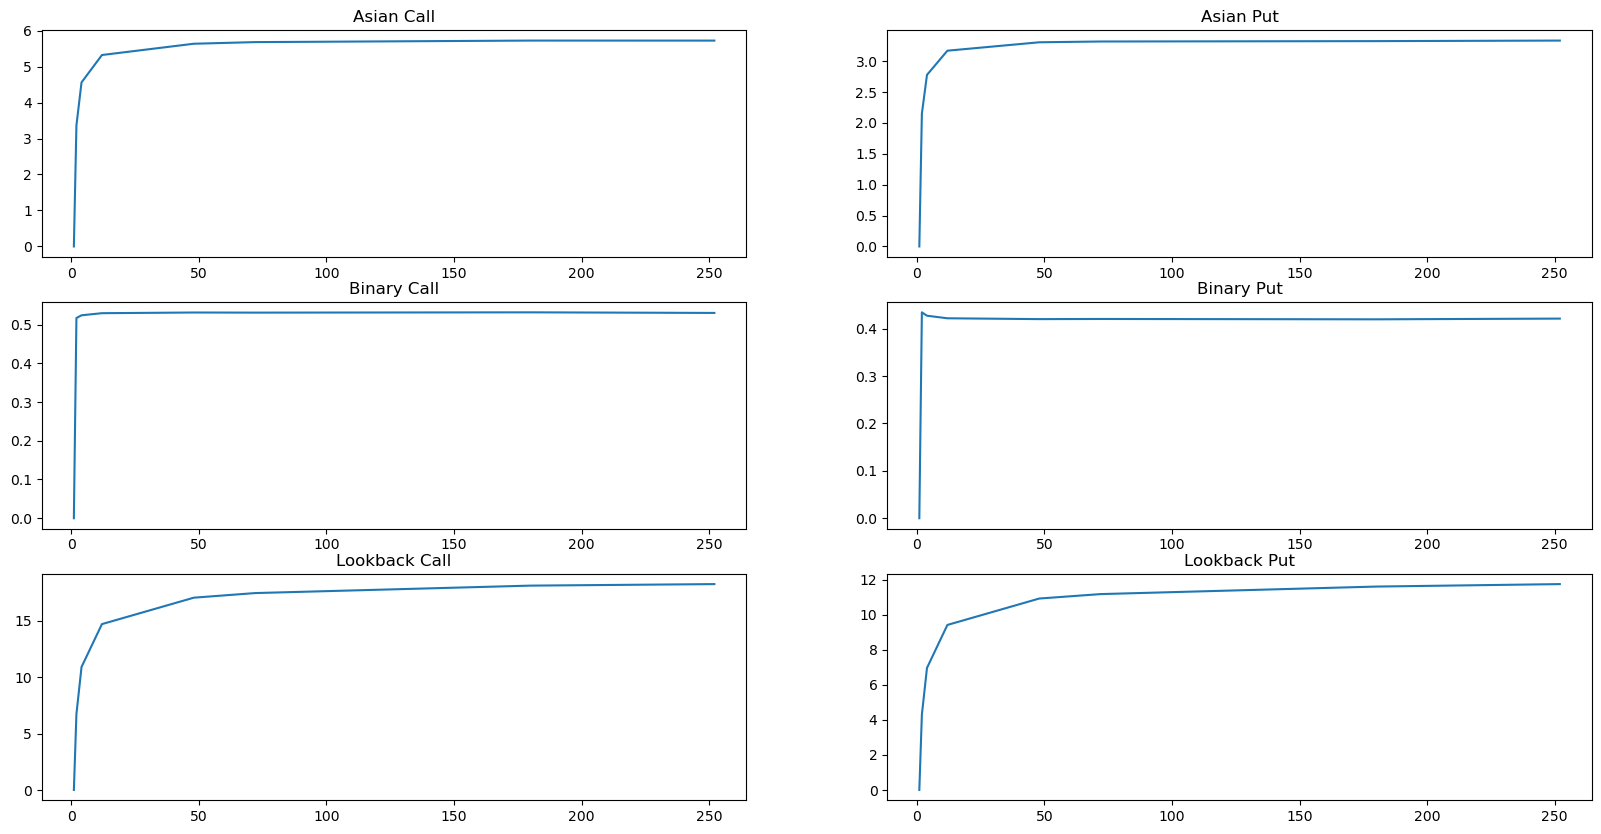

In [439]:
# Plot graph iteratively
fig, ax = plt.subplots(3,2, figsize=(20,10))

ax[0,0].plot(df_Nsteps_results.iloc[:,[0]])
ax[0,1].plot(df_Nsteps_results.iloc[:,[1]])
ax[1,0].plot(df_Nsteps_results.iloc[:,[2]])
ax[1,1].plot(df_Nsteps_results.iloc[:,[3]])
ax[2,0].plot(df_Nsteps_results.iloc[:,[4]])
ax[2,1].plot(df_Nsteps_results.iloc[:,[5]])
    
# Set axis title
ax[0,0].set_title('Asian Call'), ax[0,1].set_title('Asian Put'), 
ax[1,0].set_title('Binary Call'), ax[1,1].set_title('Binary Put'),
ax[2,0].set_title('Lookback Call'), ax[2,1].set_title('Lookback Put')

plt.show()

### Simulation Times

In [456]:
Nsim_list = [10,100,1000,10000,100000]
Nsim_results = []
for i in Nsim_list:
    ClosedForm = Monte_Carlo_ClosedForm(S0,K,r,sigma,T,Nsteps,i)
    results = [ClosedForm.AsianCall, ClosedForm.AsianPut, 
               ClosedForm.BinaryCall, ClosedForm.BinaryPut, 
               ClosedForm.LookbackCall, ClosedForm.LookbackPut]
    Nsim_results.append(results)
df_Nsim_results = pd.DataFrame(Nsim_results)
df_Nsim_results.index = Nsim_list
df_Nsim_results.index.name = 'Time Steps'
df_Nsim_results.columns = ['Asian Call', 'Asian Put', 
                             'Binary Call', 'Binary Put', 
                             'Lookback Call', 'Lookback Put']

In [457]:
round(df_Nsim_results,4)

,Asian Call,Asian Put,Binary Call,Binary Put,Lookback Call,Lookback Put
Time Steps,,,,,,
10,6.4201,5.0456,0.5707,0.3805,17.8644,13.7602
100,5.7623,3.5513,0.4281,0.5232,18.4832,12.4950
1000,5.4273,3.5452,0.5203,0.4309,18.2145,12.5459
10000,5.6884,3.3390,0.5244,0.4268,18.7221,12.1506
100000,5.7872,3.3438,0.5322,0.4190,18.9437,12.1522


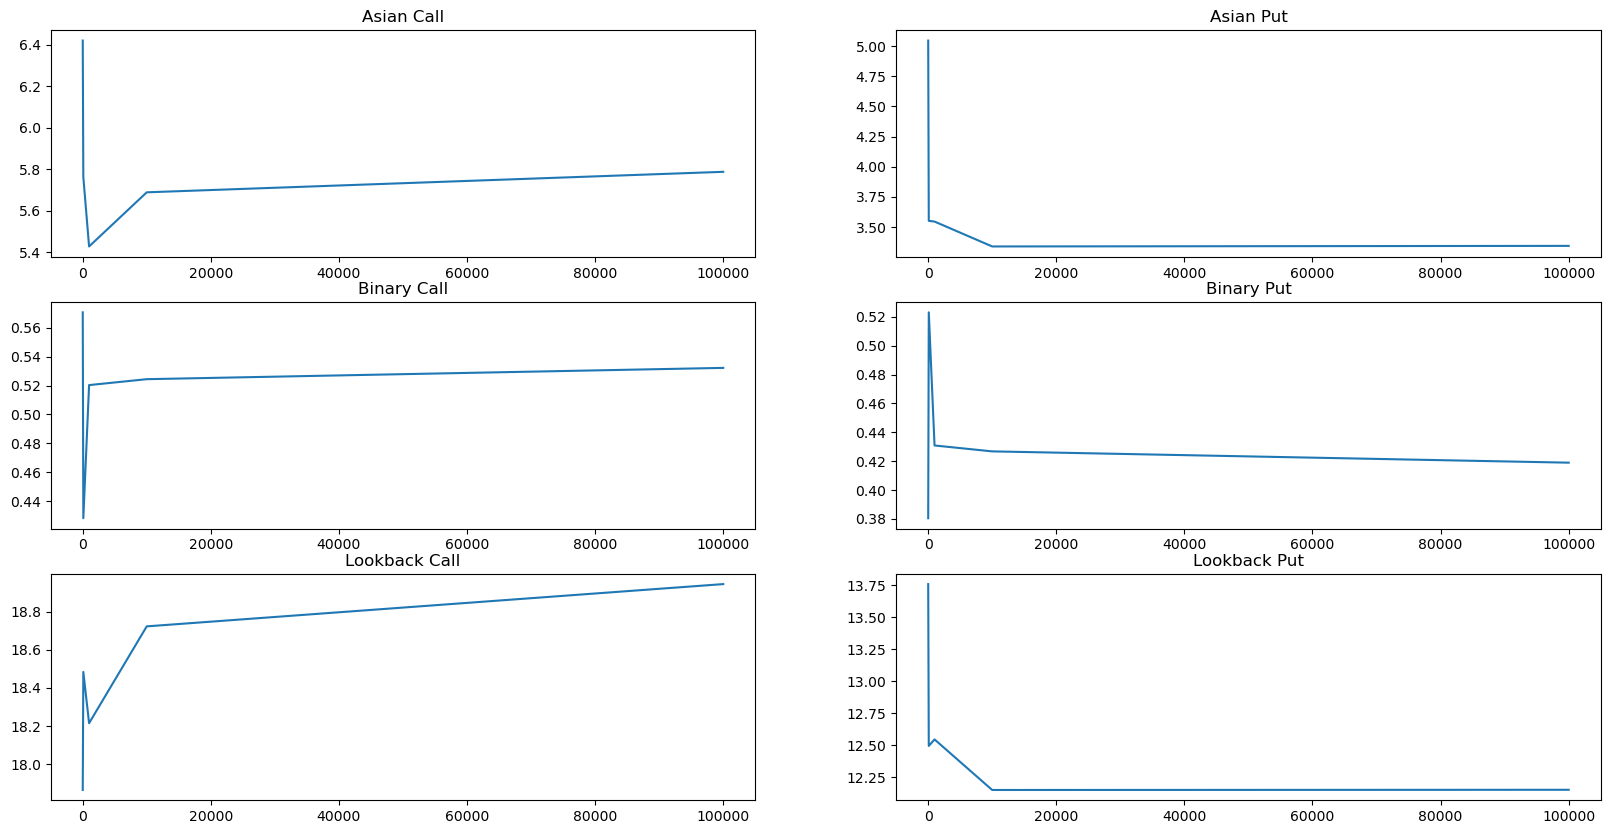

In [458]:
# Plot graph iteratively
fig, ax = plt.subplots(3,2, figsize=(20,10))

ax[0,0].plot(df_Nsim_results.iloc[:,[0]])
ax[0,1].plot(df_Nsim_results.iloc[:,[1]])
ax[1,0].plot(df_Nsim_results.iloc[:,[2]])
ax[1,1].plot(df_Nsim_results.iloc[:,[3]])
ax[2,0].plot(df_Nsim_results.iloc[:,[4]])
ax[2,1].plot(df_Nsim_results.iloc[:,[5]])
    
# Set axis title
ax[0,0].set_title('Asian Call'), ax[0,1].set_title('Asian Put'), 
ax[1,0].set_title('Binary Call'), ax[1,1].set_title('Binary Put'),
ax[2,0].set_title('Lookback Call'), ax[2,1].set_title('Lookback Put')

plt.show()

### Risk-free Rate

In [444]:
r_list = np.arange(0.01,0.11,0.01)
r_results = []
for i in r_list:
    ClosedForm = Monte_Carlo_ClosedForm(S0,K,i,sigma,T,Nsteps,Nsim)
    results = [ClosedForm.AsianCall, ClosedForm.AsianPut, 
               ClosedForm.BinaryCall, ClosedForm.BinaryPut, 
               ClosedForm.LookbackCall, ClosedForm.LookbackPut]
    r_results.append(results)
df_r_results = pd.DataFrame(r_results)
df_r_results.index = r_list
df_r_results.index.name = 'Risk-free Rate'
df_r_results.columns = ['Asian Call', 'Asian Put', 
                        'Binary Call', 'Binary Put', 
                        'Lookback Call', 'Lookback Put']

In [445]:
round(df_r_results,4)

,Asian Call,Asian Put,Binary Call,Binary Put,Lookback Call,Lookback Put
Risk-free Rate,,,,,,
0.01,4.8509,4.3280,0.4755,0.5145,17.1794,14.2212
0.02,5.0775,4.0648,0.4902,0.4900,17.6076,13.6764
0.03,5.3092,3.8131,0.5051,0.4653,18.0444,13.1504
0.04,5.5458,3.5729,0.5193,0.4415,18.4898,12.6425
0.05,5.7872,3.3438,0.5322,0.4190,18.9437,12.1522
0.06,6.0335,3.1259,0.5453,0.3964,19.4057,11.6792
0.07,6.2842,2.9186,0.5578,0.3746,19.8756,11.2230
0.08,6.5392,2.7218,0.5697,0.3534,20.3529,10.7832
0.09,6.7984,2.5353,0.5819,0.3320,20.8370,10.3594


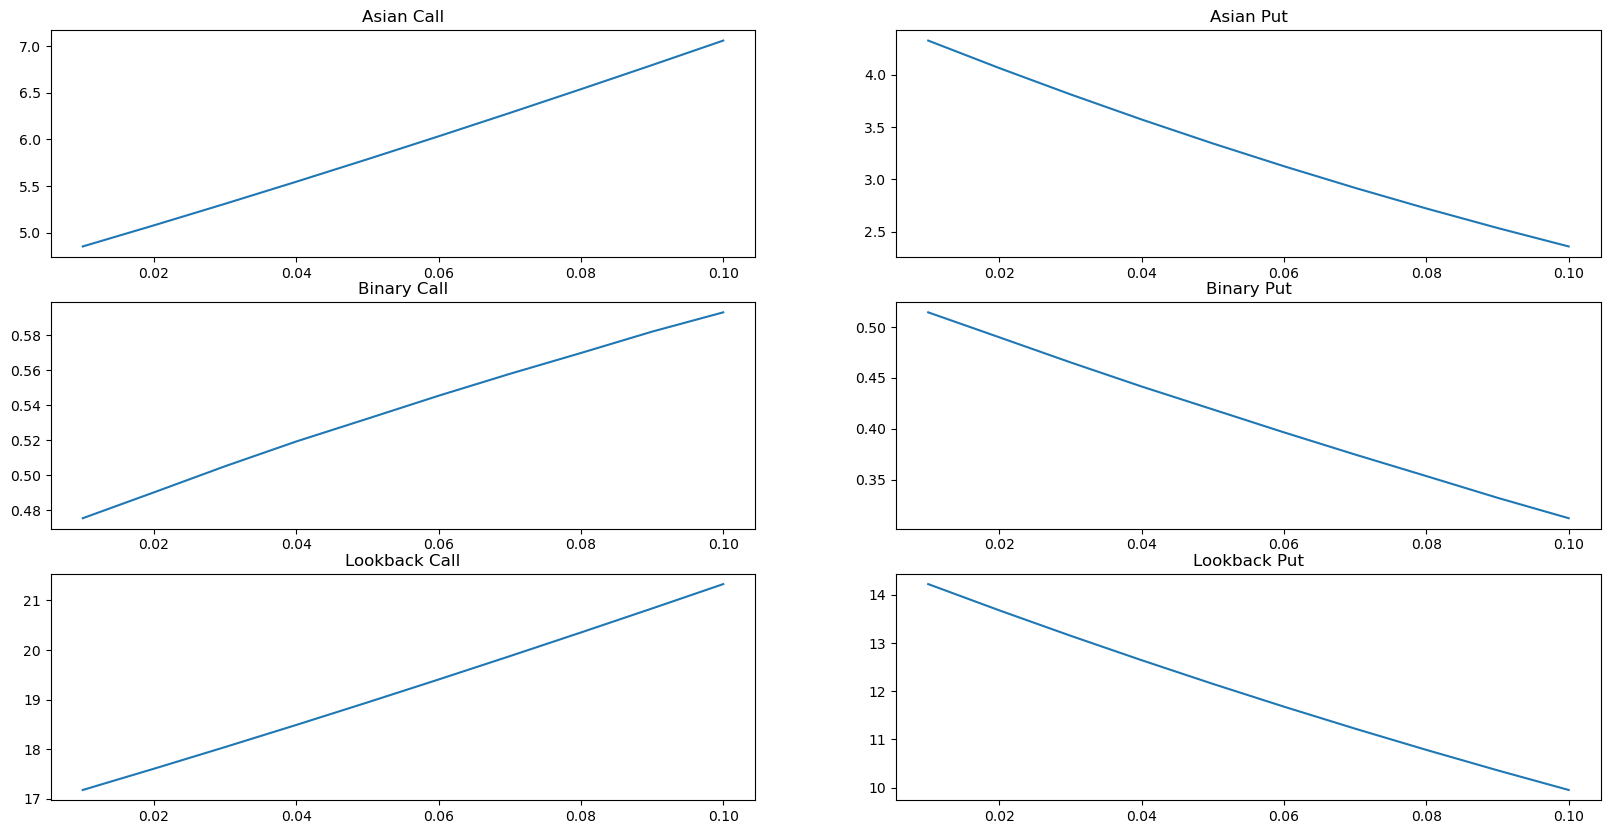

In [446]:
# Plot graph iteratively
fig, ax = plt.subplots(3,2, figsize=(20,10))

ax[0,0].plot(df_r_results.iloc[:,[0]])
ax[0,1].plot(df_r_results.iloc[:,[1]])
ax[1,0].plot(df_r_results.iloc[:,[2]])
ax[1,1].plot(df_r_results.iloc[:,[3]])
ax[2,0].plot(df_r_results.iloc[:,[4]])
ax[2,1].plot(df_r_results.iloc[:,[5]])
    
# Set axis title
ax[0,0].set_title('Asian Call'), ax[0,1].set_title('Asian Put'), 
ax[1,0].set_title('Binary Call'), ax[1,1].set_title('Binary Put'),
ax[2,0].set_title('Lookback Call'), ax[2,1].set_title('Lookback Put')

plt.show()

### Volatility

**How does the volatility affect the Binary call option price?**

In [451]:
sigma_list = np.arange(0.1,1.1,0.1)
sigma_results = []
for i in sigma_list:
    ClosedForm = Monte_Carlo_ClosedForm(S0,K,r,i,T,Nsteps,Nsim)
    results = [ClosedForm.AsianCall, ClosedForm.AsianPut, 
               ClosedForm.BinaryCall, ClosedForm.BinaryPut, 
               ClosedForm.LookbackCall, ClosedForm.LookbackPut]
    sigma_results.append(results)
df_sigma_results = pd.DataFrame(sigma_results)
df_sigma_results.index = sigma_list
df_sigma_results.index.name = 'Volatility'
df_sigma_results.columns = ['Asian Call', 'Asian Put', 
                            'Binary Call', 'Binary Put', 
                            'Lookback Call', 'Lookback Put']

In [452]:
round(df_sigma_results,4)

,Asian Call,Asian Put,Binary Call,Binary Put,Lookback Call,Lookback Put
Volatility,,,,,,
0.1,3.6499,1.2208,0.6406,0.3106,10.6814,5.3253
0.2,5.7872,3.3438,0.5322,0.4190,18.9437,12.1522
0.3,7.9891,5.5285,0.4821,0.4691,27.8279,18.6471
0.4,10.2017,7.7207,0.4479,0.5034,37.2754,24.7536
0.5,12.4126,9.9074,0.4198,0.5314,47.2871,30.4732
0.6,14.6154,12.0818,0.3951,0.5561,57.8767,35.8178
0.7,16.8058,14.2394,0.3718,0.5795,69.0635,40.8024
0.8,18.9800,16.3757,0.3498,0.6014,80.8663,45.4438
0.9,21.1362,18.4885,0.3298,0.6214,93.3019,49.7586


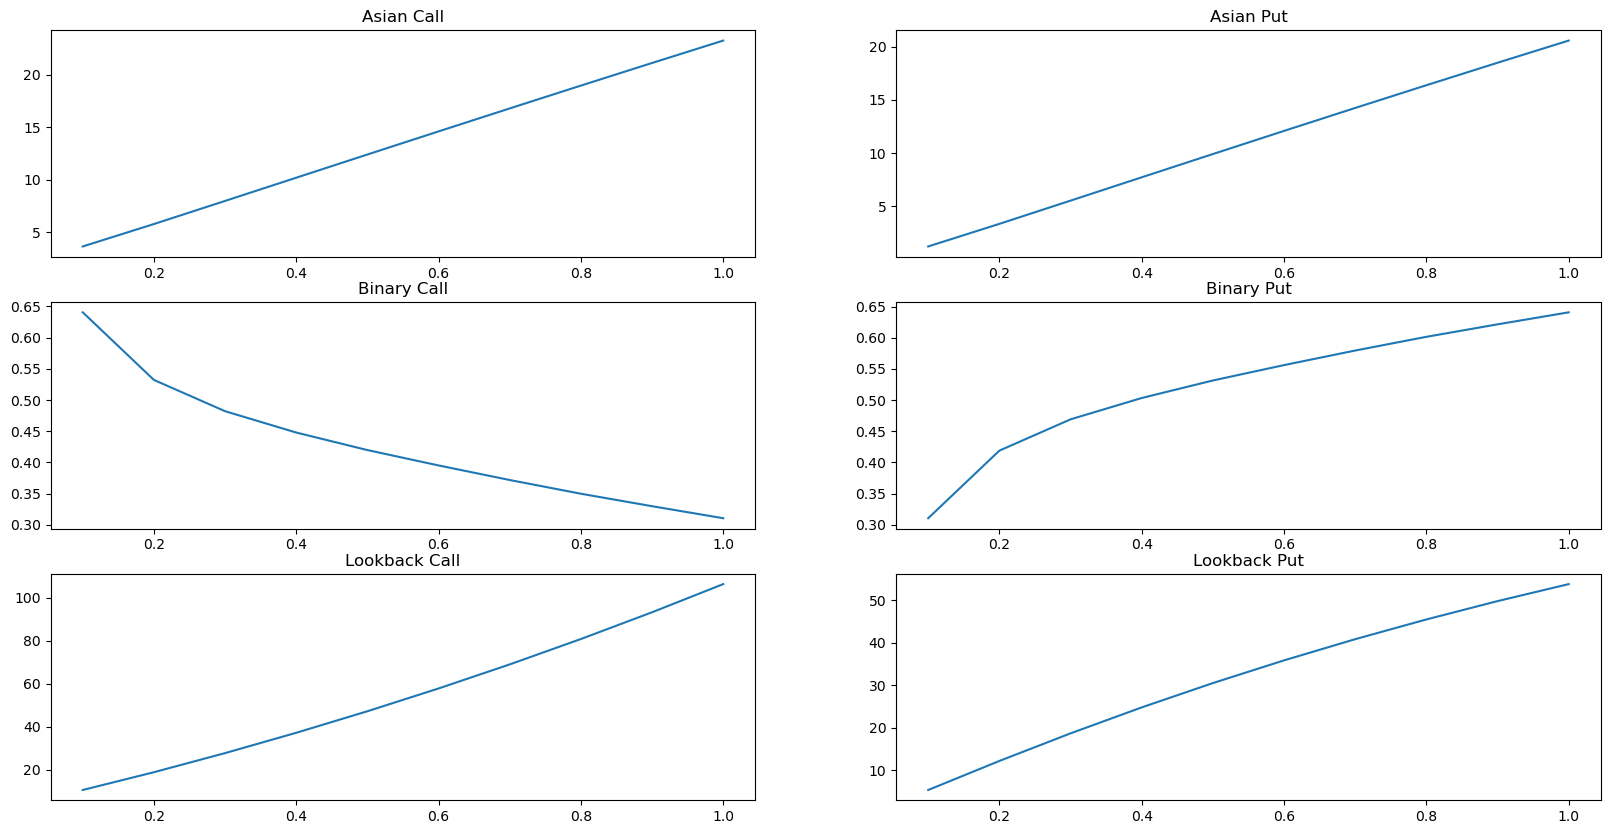

In [453]:
# Plot graph iteratively
fig, ax = plt.subplots(3,2, figsize=(20,10))

ax[0,0].plot(df_sigma_results.iloc[:,[0]])
ax[0,1].plot(df_sigma_results.iloc[:,[1]])
ax[1,0].plot(df_sigma_results.iloc[:,[2]])
ax[1,1].plot(df_sigma_results.iloc[:,[3]])
ax[2,0].plot(df_sigma_results.iloc[:,[4]])
ax[2,1].plot(df_sigma_results.iloc[:,[5]])
    
# Set axis title
ax[0,0].set_title('Asian Call'), ax[0,1].set_title('Asian Put'), 
ax[1,0].set_title('Binary Call'), ax[1,1].set_title('Binary Put'),
ax[2,0].set_title('Lookback Call'), ax[2,1].set_title('Lookback Put')

plt.show()

### Maturity

In [461]:
T_list = [1/252, 1/12, 0.25, 0.5, 1, 2]
T_results = []
for i in T_list:
    ClosedForm = Monte_Carlo_ClosedForm(S0,K,r,sigma,i,Nsteps,Nsim)
    results = [ClosedForm.AsianCall, ClosedForm.AsianPut, 
               ClosedForm.BinaryCall, ClosedForm.BinaryPut, 
               ClosedForm.LookbackCall, ClosedForm.LookbackPut]
    T_results.append(results)
df_T_results = pd.DataFrame(T_results)
df_T_results.index = T_list
df_T_results.index.name = 'Maturity'
df_T_results.columns = ['Asian Call', 'Asian Put', 
                        'Binary Call', 'Binary Put', 
                        'Lookback Call', 'Lookback Put']

In [462]:
round(df_T_results,4)

,Asian Call,Asian Put,Binary Call,Binary Put,Lookback Call,Lookback Put
Maturity,,,,,,
0.003968,0.2965,0.2852,0.5040,0.4958,1.0062,0.9768
0.083333,1.4389,1.2246,0.5157,0.4802,4.8321,4.2469
0.250000,2.6181,1.9866,0.5238,0.4638,8.7152,6.9782
0.500000,3.8701,2.6237,0.5294,0.4459,12.7847,9.3407
1.000000,5.7872,3.3438,0.5322,0.4190,18.9437,12.1522
2.000000,8.7393,4.0226,0.5281,0.3767,28.3347,15.0970


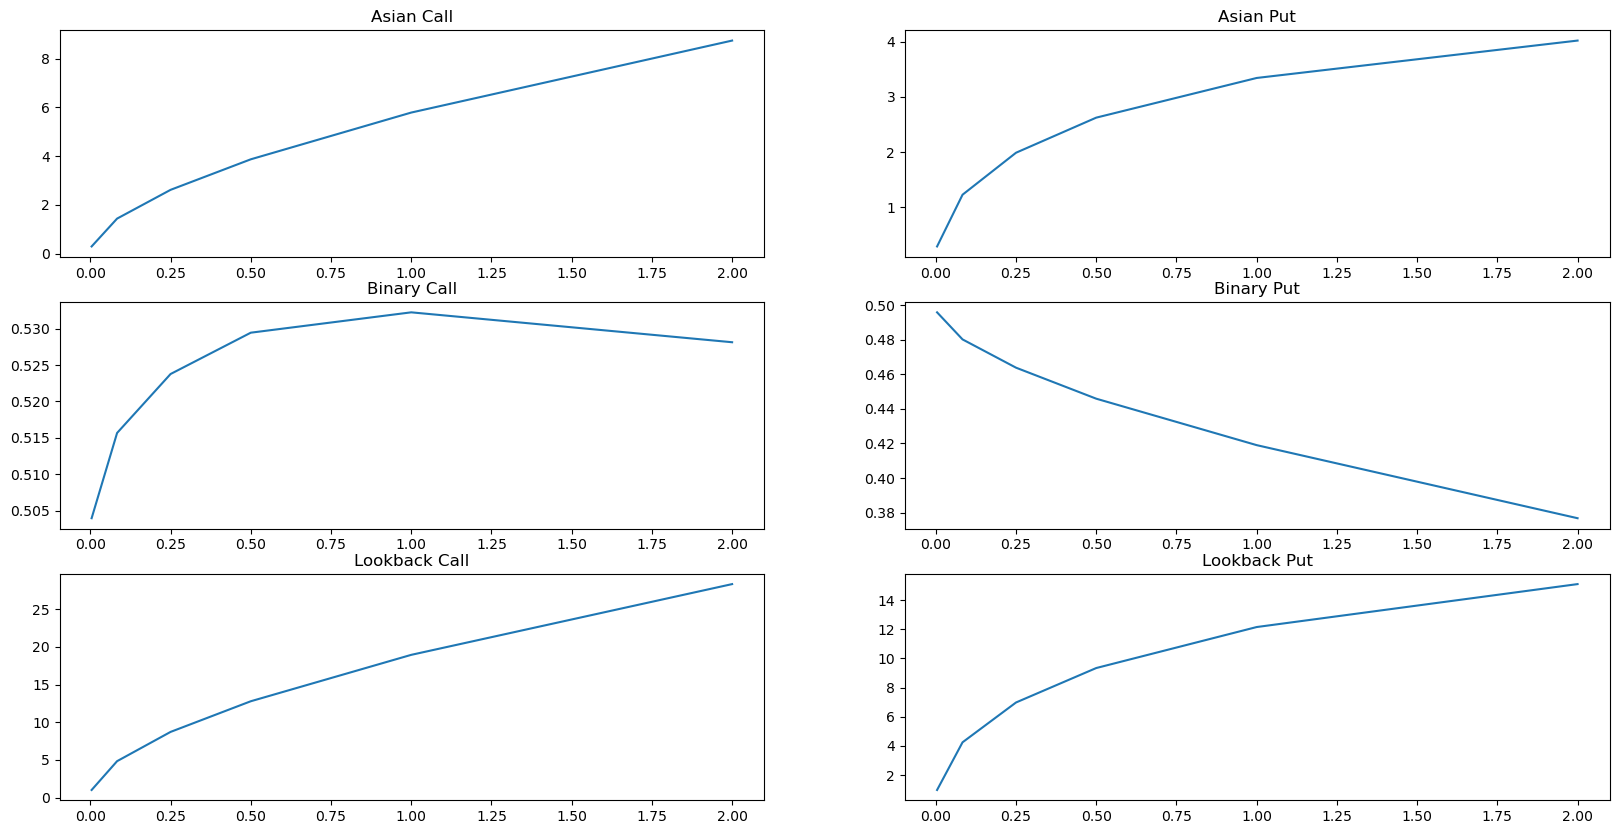

In [450]:
# Plot graph iteratively
fig, ax = plt.subplots(3,2, figsize=(20,10))

ax[0,0].plot(df_T_results.iloc[:,[0]])
ax[0,1].plot(df_T_results.iloc[:,[1]])
ax[1,0].plot(df_T_results.iloc[:,[2]])
ax[1,1].plot(df_T_results.iloc[:,[3]])
ax[2,0].plot(df_T_results.iloc[:,[4]])
ax[2,1].plot(df_T_results.iloc[:,[5]])
    
# Set axis title
ax[0,0].set_title('Asian Call'), ax[0,1].set_title('Asian Put'), 
ax[1,0].set_title('Binary Call'), ax[1,1].set_title('Binary Put'),
ax[2,0].set_title('Lookback Call'), ax[2,1].set_title('Lookback Put')

plt.show()

### Simulated Methods

In [460]:
ClosedForm = Monte_Carlo_ClosedForm(S0,K,r,sigma,T,Nsteps,Nsim)
ClosedForm_df = pd.DataFrame([ClosedForm.AsianCall, ClosedForm.AsianPut, 
                   ClosedForm.BinaryCall, ClosedForm.BinaryPut, 
                   ClosedForm.LookbackCall, ClosedForm.LookbackPut]).T

EulerMaruyama = Monte_Carlo_EulerMaruyama(S0,K,r,sigma,T,Nsteps,Nsim)
EulerMaruyama_df = pd.DataFrame([EulerMaruyama.AsianCall, EulerMaruyama.AsianPut, 
                   EulerMaruyama.BinaryCall, EulerMaruyama.BinaryPut, 
                   EulerMaruyama.LookbackCall, EulerMaruyama.LookbackPut]).T

Milstein = Monte_Carlo_Milstein(S0,K,r,sigma,T,Nsteps,Nsim)
Milstein_df = pd.DataFrame([Milstein.AsianCall, Milstein.AsianPut, 
                   Milstein.BinaryCall, Milstein.BinaryPut, 
                   Milstein.LookbackCall, Milstein.LookbackPut]).T

results_df1 = pd.concat([ClosedForm_df, EulerMaruyama_df])
results_df2 = pd.concat([results_df1, Milstein_df])

results_df2.index = ['Closed Form', 'Euler-Maruyama', 'Milstein']
results_df2.index.name = 'Methods'
results_df2.columns = ['Asian Call', 'Asian Put', 
                        'Binary Call', 'Binary Put', 
                        'Lookback Call', 'Lookback Put']

round(results_df2,6)

,Asian Call,Asian Put,Binary Call,Binary Put,Lookback Call,Lookback Put
Methods,,,,,,
Closed Form,5.787223,3.343797,0.532241,0.418988,18.943660,12.152153
Euler-Maruyama,5.787142,3.343850,0.532327,0.418902,18.943295,12.152118
Milstein,5.787121,3.343720,0.532241,0.418988,18.943288,12.151907


In [591]:
EM_diff = EM_CF/result_np[0]*100
EM_diff.round(4)

array([0.0014, 0.0016, 0.0161, 0.0204, 0.0019, 0.0003])

In [592]:
M_diff = M_CF/result_np[0]*100
M_diff.round(4)

array([0.0018, 0.0023, 0.    , 0.    , 0.002 , 0.002 ])

In [388]:
result_np = results_df2.values
EM_CF = abs(result_np[1] - result_np[0])
M_CF = abs(result_np[2] - result_np[0])

comparison = []
for i in range(len(result_np[0])):
    if EM_CF[i] < M_CF[i]:
        results = 'Euler-Maruyama'
    else:
        results = 'Milstein'
    comparison.append(results)
    
header = ['Asian Call', 'Asian Put', 'Binary Call', 'Binary Put', 'Lookback Call', 'Lookback Put']
table = [[comparison[0],comparison[1],comparison[2], 
          comparison[3],comparison[4],comparison[5]]]

print(tabulate(table,header))

Asian Call      Asian Put       Binary Call    Binary Put    Lookback Call    Lookback Put
--------------  --------------  -------------  ------------  ---------------  --------------
Euler-Maruyama  Euler-Maruyama  Milstein       Milstein      Euler-Maruyama   Euler-Maruyama


## Interesting Observations

### How does Volatility Affect the Binary Call Option Prices?

In [486]:
vol_list = np.arange(0,5.1,0.05)

**Out the Money**

In [491]:
K_OTM = 150
price_OTM = []
for i in vol_list:
    Vol_OTM = Monte_Carlo_ClosedForm(S0,K_OTM,r,i,T,Nsteps,10000)
    results = [Vol_OTM.BinaryCall, Vol_OTM.BinaryPut]
    price_OTM.append(results)
df_OTM_results = pd.DataFrame(price_OTM)
df_OTM_results.index = vol_list
df_OTM_results.index.name = 'Volatility'
df_OTM_results.columns = ['Binary Call', 'Binary Put']

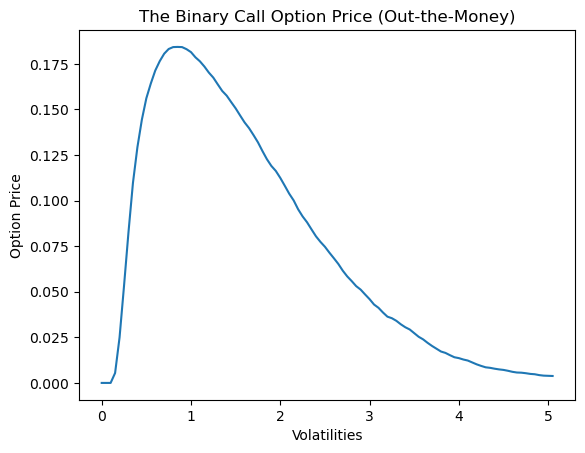

In [497]:
plt.plot(df_OTM_results.iloc[:,[0]])
plt.xlabel('Volatilities')
plt.ylabel('Option Price')
plt.title('The Binary Call Option Price (Out-the-Money)')
plt.show()

**In the Money**

In [514]:
K_ITM = 50
price_ITM = []
for i in vol_list:
    Vol_ITM = Monte_Carlo_ClosedForm(S0,K_ITM,r,i,T,Nsteps,10000)
    results = [Vol_ITM.BinaryCall, Vol_ITM.BinaryPut]
    price_ITM.append(results)
df_ITM_results = pd.DataFrame(price_ITM)
df_ITM_results.index = vol_list
df_ITM_results.index.name = 'Volatility'
df_ITM_results.columns = ['Binary Call', 'Binary Put']

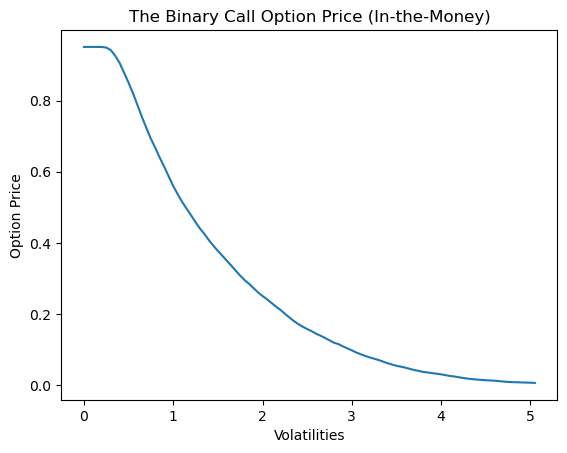

In [515]:
plt.plot(df_ITM_results.iloc[:,[0]])
plt.xlabel('Volatilities')
plt.ylabel('Option Price')
plt.title('The Binary Call Option Price (In-the-Money)')
plt.show()

**At the Money**

In [516]:
K_ATM = 100
price_ATM = []
for i in vol_list:
    Vol_ATM = Monte_Carlo_ClosedForm(S0,K_ATM,r,i,T,Nsteps,10000)
    results = [Vol_ATM.BinaryCall, Vol_ATM.BinaryPut]
    price_ATM.append(results)
df_ATM_results = pd.DataFrame(price_ATM)
df_ATM_results.index = vol_list
df_ATM_results.index.name = 'Volatility'
df_ATM_results.columns = ['Binary Call', 'Binary Put']

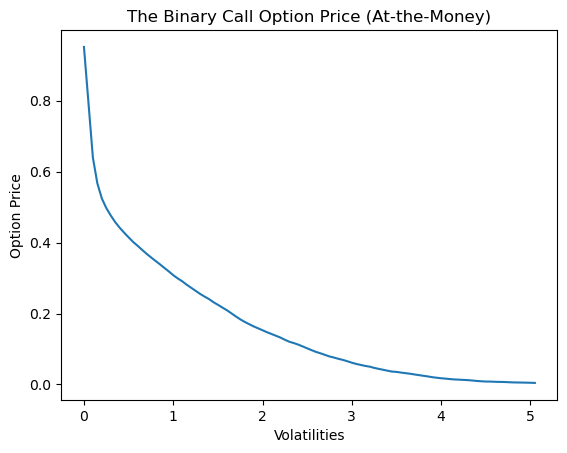

In [517]:
plt.plot(df_ATM_results.iloc[:,[0]])
plt.xlabel('Volatilities')
plt.ylabel('Option Price')
plt.title('The Binary Call Option Price (At-the-Money)')
plt.show()

### How does Maturity Affect the Binary Call Option Prices?

In [555]:
maturity_list = np.arange(0.1,2.1,0.05)

**Out the Money**

In [546]:
K_OTM = 150
price_OTM = []
for i in maturity_list:
    Mat_OTM = Monte_Carlo_ClosedForm(S0,K_OTM,r,sigma,i,Nsteps,10000)
    results = [Mat_OTM.BinaryCall, Mat_OTM.BinaryPut]
    price_OTM.append(results)
df_OTM_results = pd.DataFrame(price_OTM)
df_OTM_results.index = maturity_list
df_OTM_results.index.name = 'Maturity'
df_OTM_results.columns = ['Binary Call', 'Binary Put']

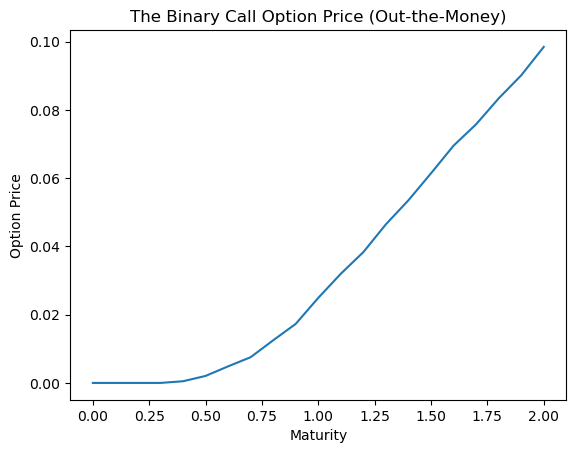

In [547]:
plt.plot(df_OTM_results.iloc[:,[0]])
plt.xlabel('Maturity')
plt.ylabel('Option Price')
plt.title('The Binary Call Option Price (Out-the-Money)')
plt.show()

**In the Money**

In [548]:
K_ITM = 50
price_ITM = []
for i in maturity_list:
    Mat_ITM = Monte_Carlo_ClosedForm(S0,K_ITM,r,sigma,i,Nsteps,10000)
    results = [Mat_ITM.BinaryCall, Mat_ITM.BinaryPut]
    price_ITM.append(results)
df_ITM_results = pd.DataFrame(price_ITM)
df_ITM_results.index = maturity_list
df_ITM_results.index.name = 'Maturity'
df_ITM_results.columns = ['Binary Call', 'Binary Put']

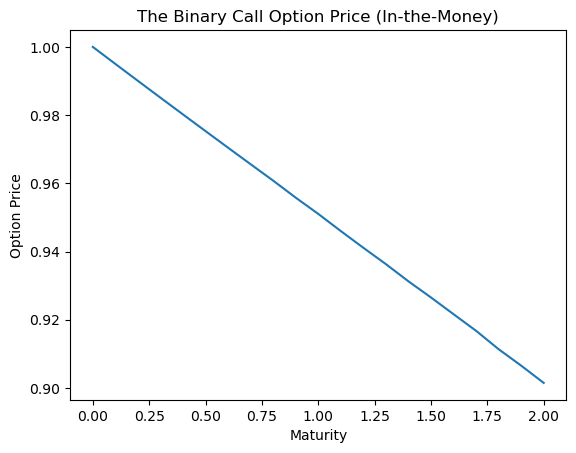

In [549]:
plt.plot(df_ITM_results.iloc[:,[0]])
plt.xlabel('Maturity')
plt.ylabel('Option Price')
plt.title('The Binary Call Option Price (In-the-Money)')
plt.show()

**At the Money**

In [558]:
K_ATM = 100
price_ATM = []
for i in maturity_list:
    Mat_ATM = Monte_Carlo_ClosedForm(S0,K_ATM,r,sigma,i,Nsteps,100000)
    results = [Mat_ATM.BinaryCall, Mat_ATM.BinaryPut]
    price_ATM.append(results)
df_ATM_results = pd.DataFrame(price_ATM)
df_ATM_results.index = maturity_list
df_ATM_results.index.name = 'Maturity'
df_ATM_results.columns = ['Binary Call', 'Binary Put']

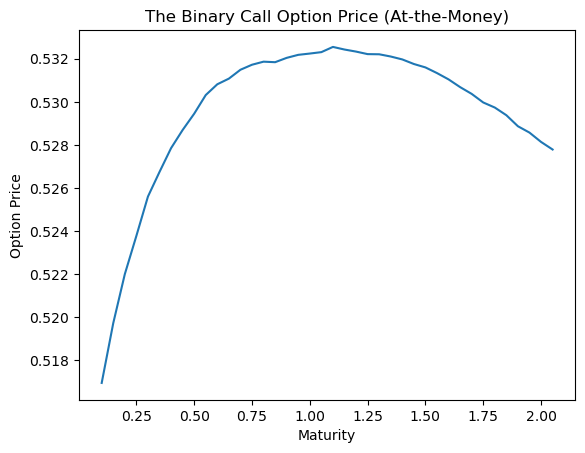

In [559]:
plt.plot(df_ATM_results.iloc[:,[0]])
plt.xlabel('Maturity')
plt.ylabel('Option Price')
plt.title('The Binary Call Option Price (At-the-Money)')
plt.show()

### Convergence

In [562]:
# SDE model parameters
mu, sigma, X0 = 2, 1, 1

# Initiate dt grid and lists to store errors
str_err_em, str_err_mil, weak_err_em, weak_err_mil = [], [], [], []
dt_grid = [2 ** (R-10) for R in range(7)]
mc = 10000

# Loop over values of dt
for Dt in dt_grid:
    
    # Setup discretized grid 
    t = np.arange(Dt, 1 + Dt, Dt)
    n = len(t)
    
    # Initiate vectors to store errors and time series
    err_em, err_mil = np.zeros(n), np.zeros(n)
    Y_sum, Xem_sum, Xmil_sum = np.zeros(n), np.zeros(n), np.zeros(n)
    
    # Generate many sample paths
    for i in range(mc):
        
        # Create Brownian Motion
        np.random.seed(i)
        dB = np.sqrt(Dt) * np.random.randn(n)
        B  = np.cumsum(dB)
        
        # Exact solution
        Y = X0 * np.exp((mu - 0.5*sigma**2)*t + sigma * B)
        
        # Simulate stochastic processes
        Xemt, Xmilt, Xem, Xmil = X0, X0, [], []
        for j in range(n):

            # Euler-Maruyama
            Xemt += mu*Xemt* Dt + sigma * Xemt * dB[j]
            Xem.append(Xemt)
            
            # Milstein
            Xmilt += mu*Xmilt*Dt + sigma*Xmilt*dB[j] 
                     + 0.5*sigma**2*Xmilt*(dB[j]**2 - Dt)
            Xmil.append(Xmilt)
            
        # Compute strong errors and add to those across from other sample paths
        err_em  += abs(Y - Xem)
        err_mil += abs(Y - Xmil)
        
        # Add Y and X values to previous sample paths
        Y_sum += Y
        Xem_sum += Xem
        Xmil_sum += Xmil
        
    # Compute mean of absolute errors and find maximum (strong error)
    str_err_em.append(max(err_em / mc))
    str_err_mil.append(max(err_mil / mc))
    
    # Compute error of means and find maximum (weak error)
    weak_err_em.append(max(abs(Y_sum - Xem_sum)/mc))
    weak_err_mil.append(max(abs(Y_sum - Xmil_sum)/mc))

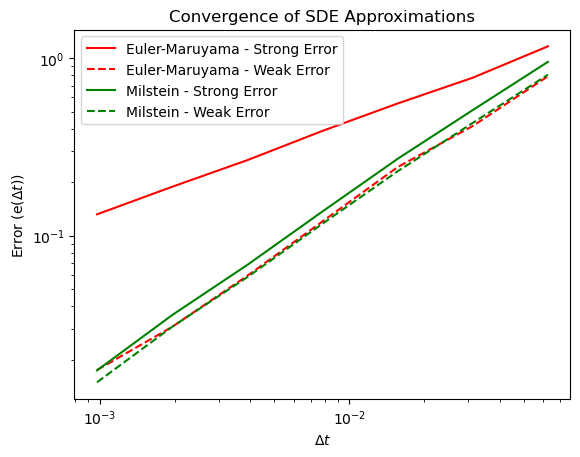

In [569]:
# Plot
plt.loglog(dt_grid, str_err_em, label="Euler-Maruyama - Strong Error",color='red')
plt.loglog(dt_grid, weak_err_em, label="Euler-Maruyama - Weak Error",color='red',ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Strong Error",color='green')
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Weak Error",color='green',ls='--')
plt.title('Convergence of SDE Approximations')
plt.xlabel('$\Delta t$'); plt.ylabel('Error (e($\Delta t$))'); plt.legend(loc=2);
plt.show()

### Antithetic Sampling

In [4]:
def normfit(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), si.sem(a)
    h = se * si.t.ppf((1 + confidence) / 2., n - 1)
    var = np.var(data, ddof=1) # Divide by n-1 
    sigma = np.sqrt(var)
    return m, sigma, np.hstack((m-h,m+h))

In [5]:
# define simulation function
def simulate_path(s0,E,mu,sigma,horizon,timesteps,n_sims,sim_method='Closed Form',option='Asian',COP='Call'):

    # set the random seed for reproducibility
    random.seed(10000)

    # read parameters
    S0 = s0                 # initial spot price
    K = E                   # strike price
    r = mu                  # mu = rf in risk neutral framework
    T = horizon             # time horizon
    t = timesteps           # number of time steps
    n = n_sims              # number of simulation

    # define dt
    dt = T/t                # length of time interval

    # simulate 'n' asset price path with 't' timesteps
    S = zeros((t,n))
    S[0] = S0

    for i in range(0, t-1):
        w = random.standard_normal(n)
        
        if sim_method == 'Closed Form':
            S[i+1] = S[i] * np.exp((r - 0.5*sigma**2)*dt + sigma*sqrt(dt)*w)
            
        if sim_method == 'Euler-Maruyama':
            S[i+1] = S[i] * (1 + r*dt + sigma*sqrt(dt)*w)
            
        if sim_method == 'Milstein':
            S[i+1] = S[i] * (1 + r*dt + sigma*sqrt(dt)*w + 0.5*sigma**2*(w**2-1)*dt)
        
    if option == 'Asian':
        average = S.mean(axis = 0)
        
        if COP == 'Call':
            payout = exp(-r*T) * maximum(0, average - K)
        else:
            payout = exp(-r*T) * maximum(0, K - average)
        
    if option == 'Binary':
        
        if COP == 'Call':
            Ind = 1*((S[-1]-K)>0)
        else:
            Ind = 1*(K-(S[-1])>0)
            
        payout = exp(-r*T) * Ind
        
    if option == 'Lookback':
        Opt = S.max(axis = 0)
        
        if COP == 'Call':
            payout = exp(-r*T) * maximum(0, Opt - K)
        else:
            payout = exp(-r*T) * maximum(0, K - Opt)

        
    price, SigPrice, CI = normfit(payout)
    
    std_error = (CI[1]-CI[0])/price

    return S, price, std_error

In [31]:
# define simulation function
def simulate_path_av(s0,E,mu,sigma,horizon,timesteps,n_sims,sim_method='Closed Form',option='Asian',COP='Call'):

    # set the random seed for reproducibility
    random.seed(10000)

    # read parameters
    S0 = s0                 # initial spot price
    K = E                   # strike price
    r = mu                  # mu = rf in risk neutral framework
    T = horizon             # time horizon
    t = timesteps           # number of time steps
    n = n_sims              # number of simulation
    n_av = int(n/2)
    
    # define dt
    dt = T/t                # length of time interval

    # simulate 'n' asset price path with 't' timesteps
    Su = zeros((t,n_av))
    Sd = zeros((t,n_av))
    Su[0] = S0
    Sd[0] = S0

    for i in range(0, t-1):
        w = random.standard_normal(n_av)
        
        if sim_method == 'Closed Form':
            Su[i+1] = Su[i] * np.exp((r - 0.5*sigma**2)*dt + sigma*sqrt(dt)*w)
            Sd[i+1] = Su[i] * np.exp((r - 0.5*sigma**2)*dt + sigma*sqrt(dt)*(-w))
            
        if sim_method == 'Euler-Maruyama':
            Su[i+1] = Su[i] * (1 + r*dt + sigma*sqrt(dt)*w)
            Sd[i+1] = Sd[i] * (1 + r*dt + sigma*sqrt(dt)*(-w))
            
        if sim_method == 'Milstein':
            Su[i+1] = Su[i] * (1 + r*dt + sigma*sqrt(dt)*w + 0.5*sigma**2*(w**2-1)*dt)
            Sd[i+1] = Sd[i] * (1 + r*dt + sigma*sqrt(dt)*(-w) + 0.5*sigma**2*((-w)**2-1)*dt)
            
    S = np.hstack((Su,Sd))
        
    if option == 'Asian':
        average = S.mean(axis = 0)
        
        if COP == 'Call':
            payout = exp(-r*T) * maximum(0, average - K)
        else:
            payout = exp(-r*T) * maximum(0, K - average)
        
    if option == 'Binary':
        
        if COP == 'Call':
            Ind = 1*((S[-1]-K)>0)
        else:
            Ind = 1*(K-(S[-1])>0)
            
        payout = exp(-r*T) * Ind
        
    if option == 'Lookback':
        Opt = S.max(axis = 0)
        
        if COP == 'Call':
            payout = exp(-r*T) * maximum(0, Opt - K)
        else:
            payout = exp(-r*T) * maximum(0, K - Opt)

        
    price, SigPrice, CI = normfit(payout)
    
    std_error = (CI[1]-CI[0])/price

    return S, price, std_error

**Asian Options**

In [32]:
m_list = [1,2,3,4,5,6]
N = [10** m for m in m_list] 

In [54]:
option = 'Asian'
COP = 'Call'
sim_method = 'Closed Form'
# price_list = []
# path_list = []
stderror_list = []
stderror_list_av = []
sim_times = [10**1, 10**2, 10**3, 10**4, 10**5]
nn = [1, 2, 3, 4, 5]
for i in sim_times:
#     sim_price = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[1]
#     sim_path  = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[0]
    sim_error    = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[2]
    sim_error_av = simulate_path_av(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[2]
#     price_list.append(sim_price)
#     path_list.append(sim_path)
    stderror_list.append(sim_error)
    stderror_list_av.append(sim_error_av)
    
stderror_df = pd.DataFrame(stderror_list)
stderror_av_df = pd.DataFrame(stderror_list_av)
stderror_sample = pd.concat((stderror_df,stderror_av_df), axis=1)
stderror_sample.columns = ['Standard', 'Antithetic Variables ']
stderror_sample.index = nn

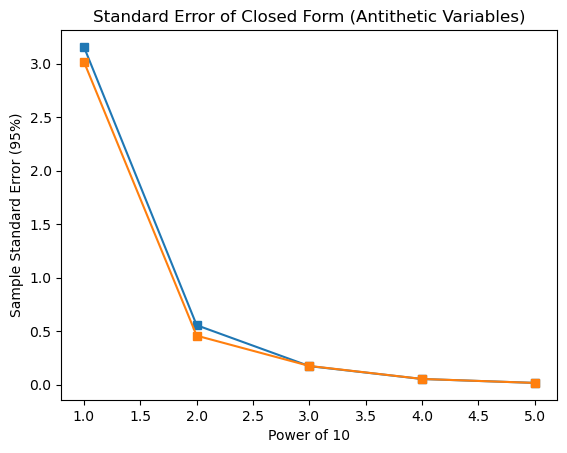

In [55]:
plt.plot(stderror_sample, marker='s')
plt.xlabel('Power of 10')
plt.ylabel('Sample Standard Error (95%)')
plt.title('Standard Error of Closed Form (Antithetic Variables)')
plt.show()

In [52]:
option = 'Asian'
COP = 'Call'
sim_method = 'Milstein'
# price_list = []
# path_list = []
stderror_list = []
stderror_list_av = []
sim_times = [10**1, 10**2, 10**3, 10**4, 10**5]
nn = [1, 2, 3, 4, 5]
for i in sim_times:
#     sim_price = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[1]
#     sim_path  = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[0]
    sim_error    = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[2]
    sim_error_av = simulate_path_av(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[2]
#     price_list.append(sim_price)
#     path_list.append(sim_path)
    stderror_list.append(sim_error)
    stderror_list_av.append(sim_error_av)
    
stderror_df = pd.DataFrame(stderror_list)
stderror_av_df = pd.DataFrame(stderror_list_av)
stderror_sample = pd.concat((stderror_df,stderror_av_df), axis=1)
stderror_sample.columns = ['Standard', 'Antithetic Variables ']
stderror_sample.index = nn

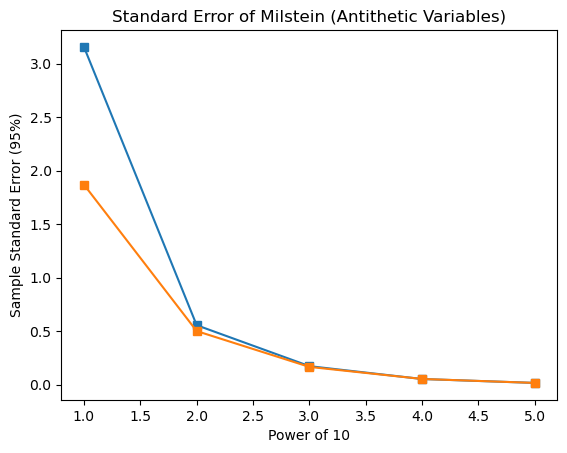

In [53]:
plt.plot(stderror_sample, marker='s')
plt.xlabel('Power of 10')
plt.ylabel('Sample Standard Error (95%)')
plt.title('Standard Error of Milstein (Antithetic Variables)')
plt.show()

In [56]:
option = 'Asian'
COP = 'Call'
sim_method = 'Euler-Maruyama'
# price_list = []
# path_list = []
stderror_list = []
stderror_list_av = []
sim_times = [10**1, 10**2, 10**3, 10**4, 10**5]
nn = [1, 2, 3, 4, 5]
for i in sim_times:
#     sim_price = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[1]
#     sim_path  = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[0]
    sim_error    = simulate_path(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[2]
    sim_error_av = simulate_path_av(S0,K,r,sigma,T,Nsteps,i,sim_method,option,COP)[2]
#     price_list.append(sim_price)
#     path_list.append(sim_path)
    stderror_list.append(sim_error)
    stderror_list_av.append(sim_error_av)
    
stderror_df = pd.DataFrame(stderror_list)
stderror_av_df = pd.DataFrame(stderror_list_av)
stderror_sample = pd.concat((stderror_df,stderror_av_df), axis=1)
stderror_sample.columns = ['Standard', 'Antithetic Variables ']
stderror_sample.index = nn

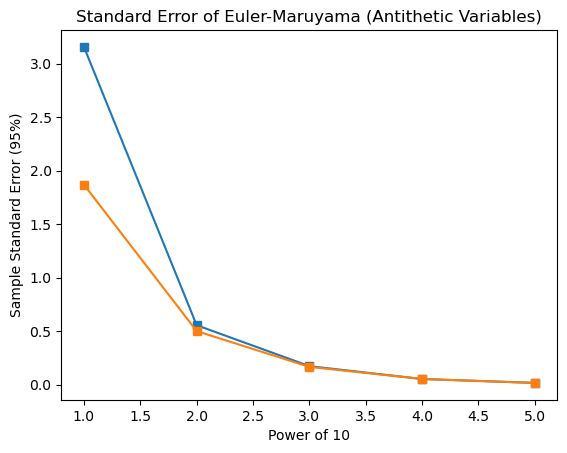

In [57]:
plt.plot(stderror_sample, marker='s')
plt.xlabel('Power of 10')
plt.ylabel('Sample Standard Error (95%)')
plt.title('Standard Error of Euler-Maruyama (Antithetic Variables)')
plt.show()